# Controlled Neural Ordinary Differential Equation for a Forced and Damped Harmonic Oscillator

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchdiffeq import odeint, odeint_adjoint
from scipy.interpolate import interp1d

def set_seed(seed=24):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)  

In [2]:
class MassSpringDamperDynamics(nn.Module):
    def __init__(self, mass=1.0, spring_k=2.0, damping_c=0.5):
        super().__init__()
        self.m = mass
        self.k = spring_k
        self.c = damping_c
        
    def forward(self, t, y, u):
        x = y[..., 0:1]   # Position
        v = y[..., 1:2]   # Velocity 
        dx_dt = v         # Rate of Change of Position (Velocity)
        dv_dt = (-self.k * x - self.c * v + u) / self.m   # Rate of Change of Velocity (Acceleration)
        return torch.cat([dx_dt, dv_dt], dim=-1)

In [3]:
def interpolate_control(t, control, dt):
    if not isinstance(t, torch.Tensor):
        t = torch.tensor([t])
    t_span = torch.arange(0, control.shape[1] * dt, dt)
    t_clamped = torch.clamp(t, min=t_span[0], max=t_span[-1])
    batch_size = control.shape[0]
    control_interp = torch.zeros(batch_size)
    
    for i in range(batch_size):
        cubic_interp = interp1d(t_span.numpy(), control[i].numpy(), kind='cubic',
                               bounds_error=False, fill_value=(control[i, 0].item(), control[i, -1].item()))
        control_interp[i] = torch.from_numpy(cubic_interp(t_clamped.numpy())).float()
    
    return control_interp

def generate_mass_spring_damper_data(n_trajectories, dt=0.1, t_final=5.0):
    t_span = torch.arange(0, t_final + dt, dt)
    
    x0 = torch.rand(n_trajectories, 1) * 4 - 2
    v0 = torch.rand(n_trajectories, 1) * 4 - 2
    state0 = torch.cat([x0, v0], dim=1)
    
    A = torch.rand(n_trajectories, 1) * 1.5 + 0.5
    w = torch.rand(n_trajectories, 1) * 1.5 + 0.5
    p = torch.rand(n_trajectories, 1) * 2 * torch.pi
    t_expanded = t_span.view(1, -1).expand(n_trajectories, -1)
    controls = A * torch.sin(w * t_expanded + p)
    
    true_system = MassSpringDamperDynamics()
    
    def dynamics_with_control(t, state):
        u = interpolate_control(t, controls, dt).unsqueeze(-1)
        return true_system(t, state, u)
    
    trajectories = odeint(dynamics_with_control, state0, t_span, method='rk4', options={'step_size': dt})
    trajectories = trajectories.transpose(0, 1)
    
    return trajectories, controls.unsqueeze(-1), t_span.view(1, -1, 1).expand(n_trajectories, -1, -1)

In [4]:
n_trajectories = 50
dt = 0.1
states, controls, times = generate_mass_spring_damper_data(n_trajectories, dt)

t = times[0,:,0]

print(states.shape)
print(controls.shape)
print(times.shape)
print(t.shape)

torch.Size([50, 51, 2])
torch.Size([50, 51, 1])
torch.Size([50, 51, 1])
torch.Size([51])


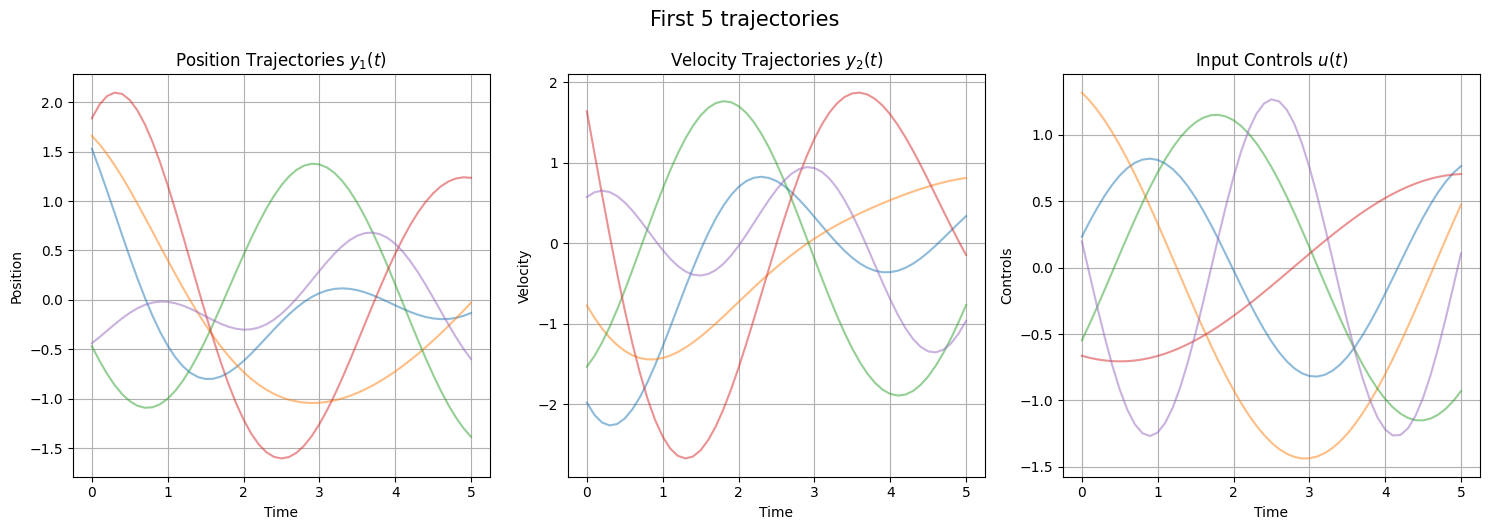

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for i in range(5):
    ax1.plot(t, states[i, :, 0], alpha=0.5)
    ax2.plot(t, states[i, :, 1], alpha=0.5)
    ax3.plot(t, controls[i,:, 0], alpha=0.5)

ax1.set_title('Position Trajectories $y_1(t)$')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.grid(True)

ax2.set_title('Velocity Trajectories $y_2(t)$')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity')
ax2.grid(True)

ax3.set_title('Input Controls $u(t)$')
ax3.set_xlabel('Time')
ax3.set_ylabel('Controls')
ax3.grid(True)

plt.tight_layout()
plt.suptitle('First 5 trajectories', y=1.05, size=15)
plt.show()

In [6]:
class ControlledNeuralODEFunc(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.acc_net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        last_layer = self.acc_net[-1]
        nn.init.uniform_(last_layer.weight,-1e-7,1e-7)
        self.control = None
        self.dt = None
        
    def forward(self, t, y):
        x = y[..., 0:1]             
        v = y[..., 1:2]          
        u = interpolate_control(t, self.control, self.dt).unsqueeze(-1)
        
        xu = torch.cat([x, v, u], dim=-1)
        
        dx_dt = v
        dv_dt = self.acc_net(xu)
        
        return torch.cat([dx_dt, dv_dt], dim=-1)

class ControlledNeuralODE(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, t_span, y0, control):
        self.func.control = control
        self.func.dt = 0.1
        pred = odeint(self.func, y0, t_span, method='rk4', options={'step_size': self.func.dt})
        return pred.transpose(0, 1)

In [7]:
y0 = states[..., 0, :] 
u  = controls[..., :, 0]
t  = times[0, :, 0]

func = ControlledNeuralODEFunc(hidden_dim=16)
node = ControlledNeuralODE(func)

pred = node(t, y0, u)

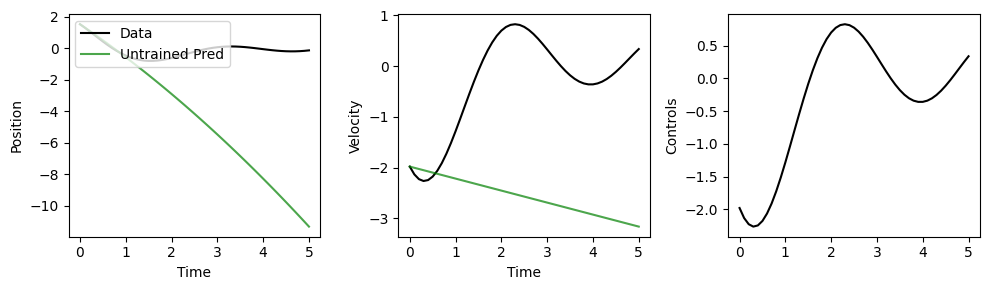

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
batch_idx = 0
ax1.plot(t, states[batch_idx, :, 0], c='black', alpha=1, label='Data')
ax1.plot(t, pred[batch_idx, :, 0].detach().cpu(), c='green', alpha=0.7, label='Untrained Pred')
ax2.plot(t, states[batch_idx, :, 1], c='black', alpha=1)
ax2.plot(t, pred[batch_idx, :, 1].detach().cpu(), c='green', alpha=0.7)
ax3.plot(t, states[batch_idx, :, 1], c='black', alpha=1, label='Controls (Forcing Function)')
ax1.legend(loc='upper left')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity')
ax3.set_ylabel('Controls')
plt.tight_layout()

In [9]:
n_epochs = 2000
optimizer = torch.optim.Adam(node.parameters(), lr=5e-3)


all_preds = []
all_losses = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    t = times[0, :, 0]
    y0 = states[..., 0, :]
    u = controls[..., :, 0]
    
    pred = node(t, y0, u)
    all_preds.append(pred.detach().clone())  
    
    loss = torch.mean((pred - states)**2)
    all_losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 250 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

all_preds = torch.stack(all_preds)           # [n_epochs, batch_size, n_times, state_dim]

Epoch 250, Loss: 0.0547
Epoch 500, Loss: 0.0093
Epoch 750, Loss: 0.0026
Epoch 1000, Loss: 0.0016
Epoch 1250, Loss: 0.0010
Epoch 1500, Loss: 0.0007
Epoch 1750, Loss: 0.0004
Epoch 2000, Loss: 0.0003


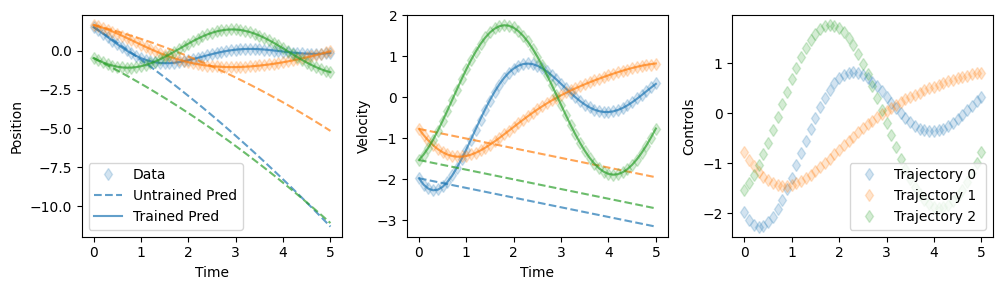

In [66]:
pred_i = all_preds[0]
pred_f = all_preds[-1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for batch_idx in range(3):
    ax1.plot(t, states[batch_idx, :, 0], marker='d', ls='', color=colors[batch_idx], alpha=0.2, label='Data')
    ax1.plot(t, pred_i[batch_idx, :, 0].detach().cpu(), ls='--', color=colors[batch_idx], alpha=0.7, label='Untrained Pred')
    ax1.plot(t, pred_f[batch_idx, :, 0].detach().cpu(), color=colors[batch_idx], alpha=0.7, label='Trained Pred')
    ax2.plot(t, states[batch_idx, :, 1], marker='d', ls='', color=colors[batch_idx], alpha=0.2)
    ax2.plot(t, pred_i[batch_idx, :, 1].detach().cpu(), ls='--', color=colors[batch_idx], alpha=0.7)
    ax2.plot(t, pred_f[batch_idx, :, 1].detach().cpu(), color=colors[batch_idx], alpha=0.7)
    ax3.plot(t, states[batch_idx, :, 1], marker='d', ls='', color=colors[batch_idx], alpha=0.2, label=f'Trajectory {batch_idx} ')
    if batch_idx == 0:
        ax1.legend(loc='lower left')
ax3.legend(loc='lower right')
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax2.set_xlabel('Time')
ax2.set_ylabel('Velocity')
ax3.set_ylabel('Controls')
plt.tight_layout()
plt.savefig('before_after.png',dpi=300)

In [23]:
all_preds[0].shape

torch.Size([50, 51, 2])

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1, ax2, ax3, ax4 = axes.flatten()

for i in range(int(all_preds.shape[0]/2)):
    # Clear all axes
    for ax in axes.flatten():
        ax.clear()
    
    pred = all_preds[i]
    for batch_idx in range(3):
        # Position plots
        ax1.plot(t, states[batch_idx, :, 0], marker='d', ls='', color=colors[batch_idx], 
                alpha=0.5, label=f'Data')
        ax1.plot(t, pred[batch_idx, :, 0].detach().cpu(), ls='--', color=colors[batch_idx], 
                alpha=0.7, label=f'Pred')
        
        # Velocity plots
        ax2.plot(t, states[batch_idx, :, 1], marker='d', ls='', color=colors[batch_idx], 
                alpha=0.5)
        ax2.plot(t, pred[batch_idx, :, 1].detach().cpu(), ls='--', color=colors[batch_idx], 
                alpha=0.7)
        
        # Control plots
        ax3.plot(t, controls[batch_idx, :, 0], color=colors[batch_idx], ls='-', 
                alpha=1, label=f'Trajectory {batch_idx}')
    
    ax4.plot(np.log10(all_losses[:i+1]), c='black', label=f'Loss at Epoch {i}')
    current_max = i + 1
    padding = max(current_max * 0.1, 10)  # 10% padding or minimum 5 epochs
    ax4.set_xlim(-padding, current_max + padding)
    
    
    # Set labels and legends
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_ylim(-1.8,1.8)
    ax1.legend(loc='lower left')
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Velocity')
    ax2.set_ylim(-2.5,2.25)
    
    ax3.set_ylabel('Controls')
    ax3.set_xlabel('Time')
    ax3.legend()
    
    ax4.set_ylabel('$\log_{10}(Loss)$')
    ax4.set_xlabel('Epoch')
    ax4.legend(loc='upper right')
    ax4.set_xlim(0, int(all_preds.shape[0]/2))
    
    plt.tight_layout()
    fig.savefig(f'plots_ncode_harmonic_oscillator/{i}.png', dpi=150)
plt.close()

# Animation

In [63]:
def create_single_mass_animation(t, states, controls, duration, batch_indices=None, max_fps=30, filename='mass_spring.gif'):
    if batch_indices is None:
        batch_indices = [0]
    
    t = t.detach().cpu().numpy()
    states = states.detach().cpu().numpy()
    controls = controls.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.axes([0.1, 0.15, 0.8, 0.75])
    
    positions = states[batch_indices, :, 0]
    max_displacement = np.max(np.abs(positions))
    max_control = np.max(np.abs(controls[batch_indices]))
    
    ax.set_xlim(-max_displacement*1.5, max_displacement*1.5)
    ax.set_ylim(-1.0, 1.0)
    
    masses = []
    springs = []
    mass_labels = []
    force_arrows = [None] * len(batch_indices)  # Initialize list to store arrow objects
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for idx, batch_idx in enumerate(batch_indices):
        mass, = ax.plot([], [], 'o', color=colors[idx], markersize=25, 
                       label=f'Mass {batch_idx}', alpha=0.5)
        spring, = ax.plot([], [], '-', color=colors[idx], linewidth=2, alpha=0.3)
        label = ax.text(0, 0, f'M{batch_idx}', ha='center', va='bottom')
        
        masses.append(mass)
        springs.append(spring)
        mass_labels.append(label)
    
    ax.plot(0, 0, 'ks', markersize=25, label='Wall', alpha=0.5)
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    def animate(i):
        artists = []
        for j, batch_idx in enumerate(batch_indices):
            x = states[batch_idx, i, 0]
            u = controls[batch_idx, i]
            
            masses[j].set_data([x], [0])
            springs[j].set_data([0, x], [0, 0])
            mass_labels[j].set_position((x, 0.15))
            
            # Remove previous arrow if it exists
            if force_arrows[j] is not None:
                force_arrows[j].remove()
            
            # Create new arrow
            arrow_length = float(u / max_control * 0.5)
            force_arrows[j] = ax.annotate('', xy=(x + arrow_length, 0), xytext=(x, 0),
                                        arrowprops=dict(arrowstyle='->',
                                                      color=colors[j],
                                                      alpha=0.7,
                                                      linewidth=2))
            
            artists.extend([masses[j], springs[j], mass_labels[j], force_arrows[j]])
        
        time_text.set_text(f'Time: {t[i]:.2f} s\nForce: {u:.2f}')
        artists.append(time_text)
        return artists
    
    ax.grid(True, alpha=0.3)
    ax.set_title("Horizontal Mass-Spring System with Control Forces")
    ax.set_xlabel("Displacement from Equilibrium")
    ax.set_yticks([])
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    
    plt.tight_layout()
    
    num_frames = len(t)
    fps = min(num_frames / duration, max_fps)
    step = max(1, int(num_frames / (fps * duration)))
    frames = range(0, num_frames, step)
    interval = duration * 1000 / len(frames)
    
    anim = FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
    anim.save(filename, writer='pillow', fps=fps)
    plt.close(fig)

In [64]:
# For single trajectory
create_single_mass_animation(t, states, controls[..., :, 0], duration=5, batch_indices=[0], 
                           filename='single_mass_spring.gif')

# For multiple trajectories
create_single_mass_animation(t, states, controls[..., :, 0], duration=5, batch_indices=range(5), 
                           filename='five_mass_spring.gif')

/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_99327/3642315459.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/hz/wjg31ld52r9cp4r029dnh6vm0000gn/T/ipykernel_99327/3642315459.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
